In [1]:
import rasterio

In [2]:
from rasterio.mask import mask
import geopandas as gpd
import fiona
import pandas as pd

In [3]:
ras = 'data/stanford-td754wr4701-geotiff.tiff' # already interpolated but we will treat it as "data"

In [4]:
shp = 'data/tl_2022_06073_faces.shp'

In [5]:
gdf = gpd.read_file(shp)

In [6]:
gdf.shape

(57076, 46)

In [7]:
gdf.head()

,TFID,STATEFP20,COUNTYFP20,TRACTCE20,BLKGRPCE20,BLOCKCE20,SUFFIX1CE,ZCTA5CE20,UACE20,PUMACE20,...,METDIVFP,CNECTAFP,NECTAFP,NCTADVFP,LWFLAG,OFFSET,ATOTAL,INTPTLAT,INTPTLON,geometry
0,216102682,06,073,016302,2,2010,None,92021,78661,07313,...,None,None,None,None,L,N,22408,+32.8008387,-116.9453919,"POLYGON ((-116.94621 32.80044, -116.94621 32.8..."
1,216102683,06,073,016302,2,2006,None,92021,78661,07313,...,None,None,None,None,L,N,29220,+32.8008392,-116.9472819,"POLYGON ((-116.94836 32.80045, -116.94836 32.8..."
2,216102684,06,073,016302,2,2007,None,92021,78661,07313,...,None,None,None,None,L,N,18605,+32.8012731,-116.9487743,"POLYGON ((-116.94919 32.80063, -116.94919 32.8..."
3,226900092,06,073,016301,2,2003,None,92020,78661,07313,...,None,None,None,None,L,N,19567,+32.7999949,-116.9608656,"POLYGON ((-116.96140 32.80088, -116.96073 32.8..."
4,263464856,06,073,016301,2,2001,None,92020,78661,07313,...,None,None,None,None,L,N,23766,+32.8019391,-116.9605314,"POLYGON ((-116.96149 32.80194, -116.96141 32.8..."


In [23]:
county = gdf.dissolve(by='COUNTYFP20')
county.to_file("sdcounty.geojson")

<Axes: >

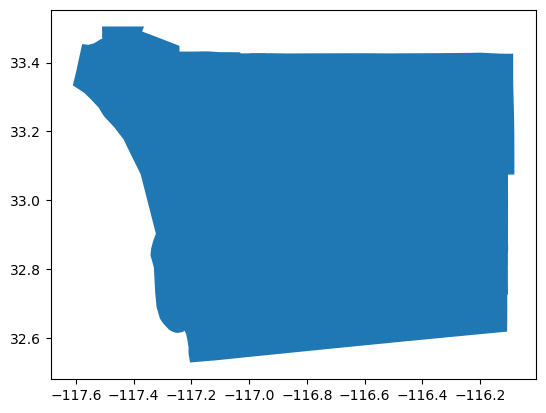

In [9]:
county.plot()

In [10]:
rast = rasterio.open(ras)

In [11]:
county = county.to_crs(rast.crs)

<Axes: >

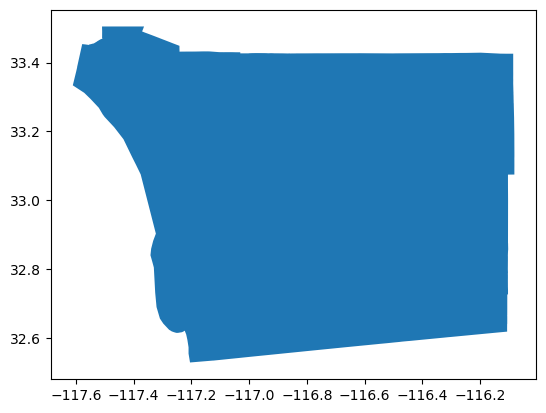

In [19]:
county.plot()

In [20]:
rast.crs

CRS.from_epsg(4326)

In [21]:
coords = gdf.geometry
src = rast
df = county
import matplotlib.pyplot as plt
from rasterio.plot import show

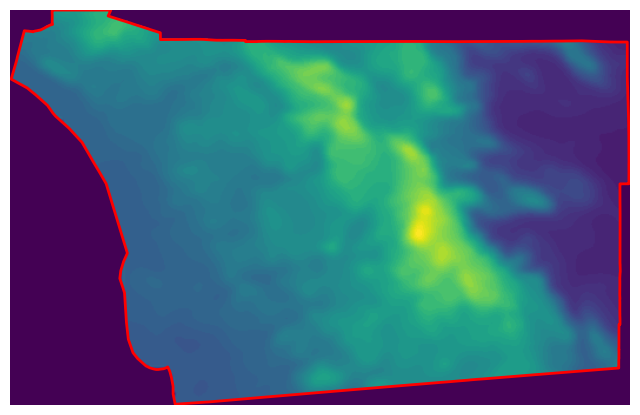

In [22]:
clipped_array, clipped_transform = mask(dataset=src, shapes=coords, crop=True)

df = df.to_crs(src.crs)
out_meta = src.meta.copy()
out_meta.update({"driver": "GTiff",
                 "height": clipped_array.shape[1],## 
                 "width": clipped_array.shape[2],
                 "transform": clipped_transform})
out_tif= "clipped_example.tif"
with rasterio.open(out_tif, "w", **out_meta) as dest:
    dest.write(clipped_array)
    
clipped = rasterio.open(out_tif)
fig, ax = plt.subplots(figsize=(8, 6))
p1 = df.plot(color=None,facecolor='none',edgecolor='red',linewidth = 2,ax=ax)
show(clipped, ax=ax)
ax.axis('off');

In [16]:
clipped

<open DatasetReader name='clipped_example.tif' mode='r'>

In [17]:
import rioxarray

In [18]:
d = rioxarray.open_rasterio("clipped_example.tif")

In [19]:
d

<xarray.DataArray (band: 1, y: 336, x: 527)>
[177072 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -117.6 -117.6 -117.6 ... -116.1 -116.1 -116.1
  * y            (y) float64 33.5 33.5 33.5 33.5 ... 32.54 32.53 32.53 32.53
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

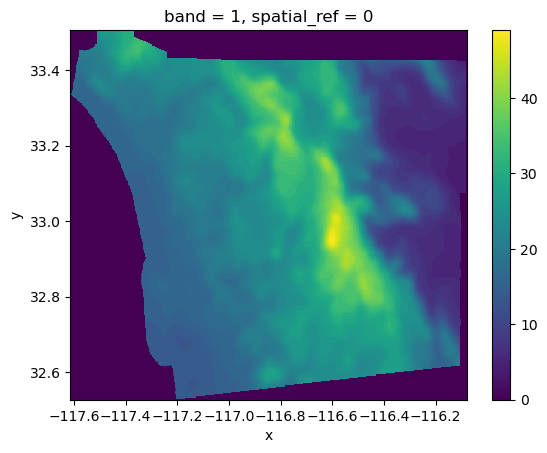

In [20]:
d.plot()

In [21]:
d.values.max()

49

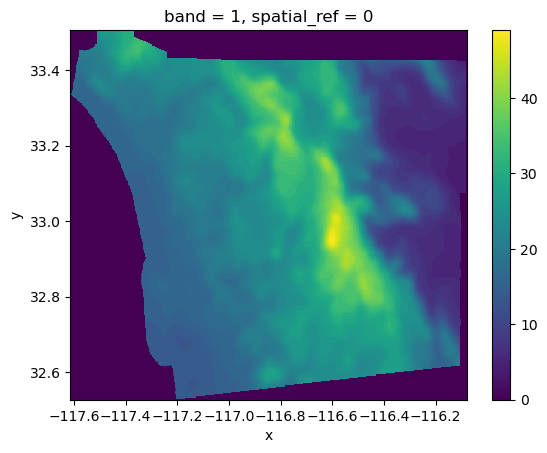

In [22]:
d.plot()

In [23]:
type(d)

xarray.core.dataarray.DataArray

In [24]:
d.dims

('band', 'y', 'x')

In [25]:
d.values.mean()

15.630963675792898

In [26]:
import numpy


In [27]:
numpy.median(d.values)

17.0

In [28]:
d.values.shape

(1, 336, 527)

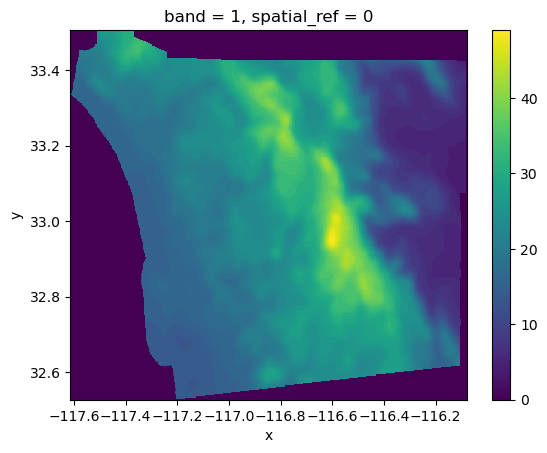

In [29]:
d.plot()

(array([44849., 17108., 10090., 29702., 31657., 23051., 11786.,  6411.,
         2011.,   407.]),
 array([ 0. ,  4.9,  9.8, 14.7, 19.6, 24.5, 29.4, 34.3, 39.2, 44.1, 49. ]),
 <BarContainer object of 10 artists>)

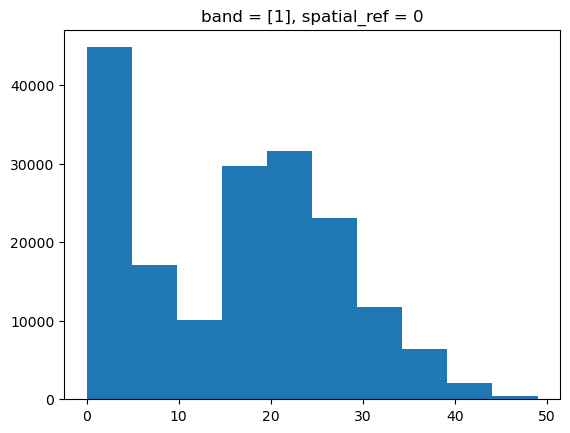

In [30]:
d.plot.hist()

In [31]:
type(d)



xarray.core.dataarray.DataArray

### Sampling the raster for "observations"

In [32]:
import numpy
numpy.random.seed(12345)
sample_points = county.sample_points(50)

In [33]:
m = county.explore()
sample_points.explore(m=m, color='red')

### Ensure sample points are separated by some threshold

In [34]:
county.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [35]:
orig_crs = county.crs

In [36]:
county_utm = county.to_crs(county.estimate_utm_crs())

<Axes: >

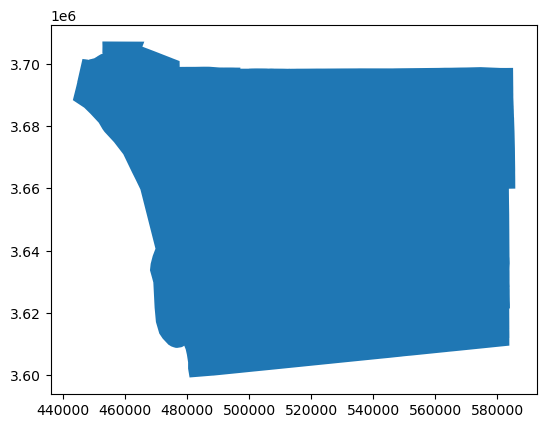

In [37]:
county_utm.plot()

In [38]:
threshold = 10000 # no pair of stations within 10000 meters of each other

In [39]:
n_points = 25 # number of stations desired

In [40]:
numpy.random.seed(12345)
thinning = True
sample_points = county_utm.sample_points(n_points * 4).explode(index_parts=True)
candidates = []
t2 = threshold**2
iter = 0
while thinning:
    p0 = numpy.random.choice(sample_points,1)[0]
    #p0 = sample_points[0]
    d0 = (sample_points.x - p0.x)**2 + (sample_points.y - p0.y)**2
    candidates.append(p0)
    if len(candidates) == n_points:
        thinning=False
    else:
        sample_points = sample_points[d0>t2]
    #print('iter: ', iter, 'shape sp: ', sampled_points.shape)
    iter += 1




In [41]:
cp = gpd.GeoSeries(candidates)

<Axes: >

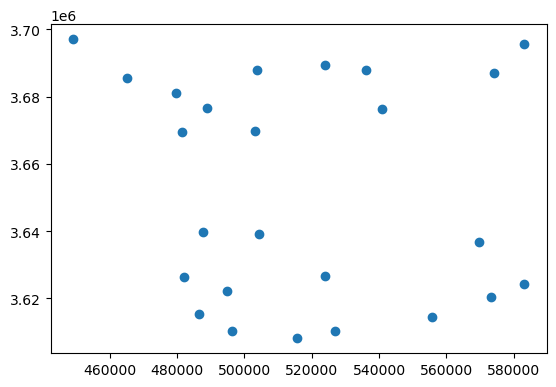

In [42]:
cp.plot()

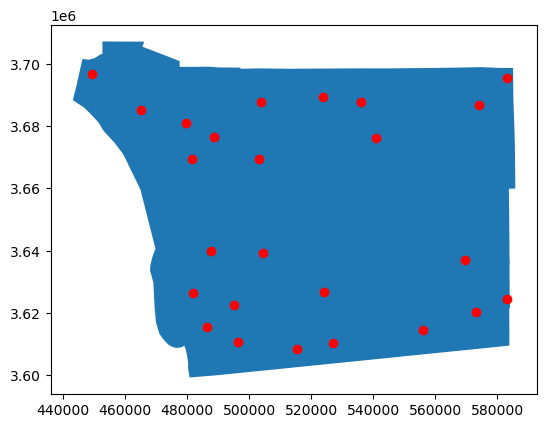

In [43]:
m = county_utm.plot()
cp.plot(ax=m, color='r');

In [44]:
cp.crs = county_utm.crs
cp = cp.to_crs(county.crs)

In [45]:
m = county.explore()
cp.explore(m=m, color='r')

In [46]:
coord_list = [(x, y) for x, y in zip(cp.x, cp.y)]

observations = [x[0] for x in clipped.sample(coord_list)]
precip_gdf = gpd.GeoDataFrame(data=observations, columns=['inches'], geometry=cp)


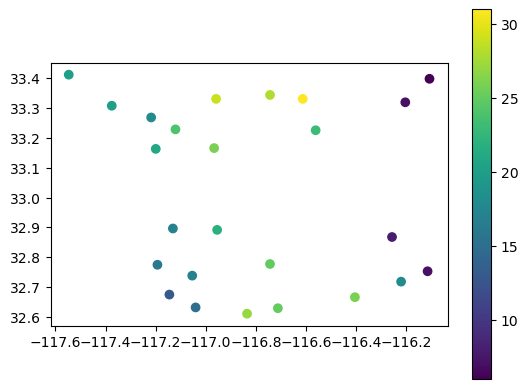

In [47]:
precip_gdf.plot(column='inches', legend=True);

In [48]:
m = county.explore()
precip_gdf.explore(column='inches', m=m)

In [49]:
precip_gdf.to_file("precip_sd.geojson", driver='GeoJSON')
county.to_file("sdcounty.geojson", driver='GeoJSON')